In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import shap

# Load dataset

In [35]:
dataset = pd.read_csv('adult.csv', header=None)
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Exploratory Data Analysis (EDA)


Dataset Preview:
   0                  1       2           3   4                    5    
0  39          State-gov   77516   Bachelors  13        Never-married  \
1  50   Self-emp-not-inc   83311   Bachelors  13   Married-civ-spouse   
2  38            Private  215646     HS-grad   9             Divorced   
3  53            Private  234721        11th   7   Married-civ-spouse   
4  28            Private  338409   Bachelors  13   Married-civ-spouse   

                   6               7       8        9     10  11  12   
0        Adm-clerical   Not-in-family   White     Male  2174   0  40  \
1     Exec-managerial         Husband   White     Male     0   0  13   
2   Handlers-cleaners   Not-in-family   White     Male     0   0  40   
3   Handlers-cleaners         Husband   Black     Male     0   0  40   
4      Prof-specialty            Wife   Black   Female     0   0  40   

               13      14  
0   United-States   <=50K  
1   United-States   <=50K  
2   United-States   <=50K  

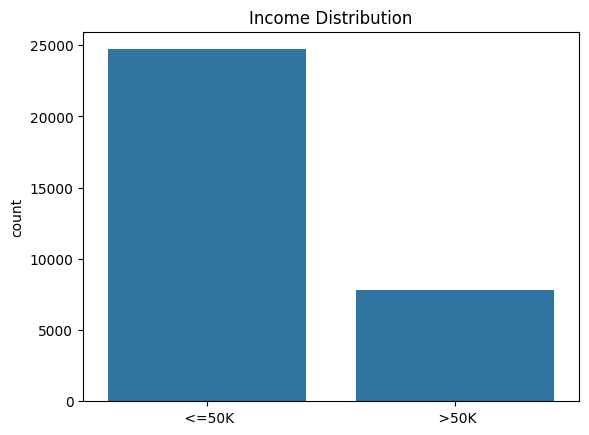

In [36]:
# Exploratory Data Analysis (EDA)
print("Dataset Preview:")
print(dataset.head())

print("\nDataset Info:")
print(dataset.info())

print("\nTarget Variable Distribution:")
sns.countplot(x=y)
plt.title("Income Distribution")
plt.show()


# Handle missing values

In [37]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X[:, 1:] = imputer.fit_transform(X[:, 1:])

# Encode categorical features

In [38]:
categorical_indices = [1, 3, 5, 6, 7, 8, 9, 13]  # Indices of categorical columns
label_encoders = {}
for index in categorical_indices:
    le = LabelEncoder()
    X[:, index] = le.fit_transform(X[:, index])
    label_encoders[index] = le


# Encode target variable

In [39]:
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

# Split data into training and testing sets


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Feature scaling


In [41]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model with Hyperparameter Tuning

In [42]:
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}


# Model Evaluation

In [43]:
y_pred = best_model.predict(X_test)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")


Confusion Matrix:
[[4654  288]
 [ 504 1067]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4942
           1       0.79      0.68      0.73      1571

    accuracy                           0.88      6513
   macro avg       0.84      0.81      0.83      6513
weighted avg       0.87      0.88      0.88      6513


Accuracy: 0.88


# Cross-Validation


In [44]:
cv_scores = cross_val_score(best_model, X_train, y_train, cv=10)
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")


Cross-Validation Accuracy: 0.87 ± 0.01


# Feature Importance


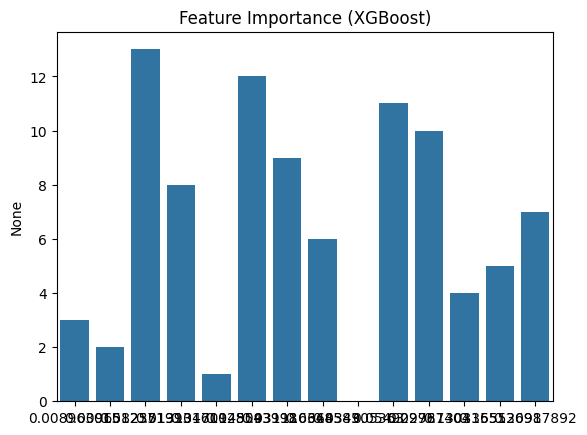

In [45]:
feature_importances = best_model.feature_importances_
sns.barplot(x=feature_importances, y=dataset.columns[:-1])
plt.title("Feature Importance (XGBoost)")
plt.show()

# SHAP Explainability

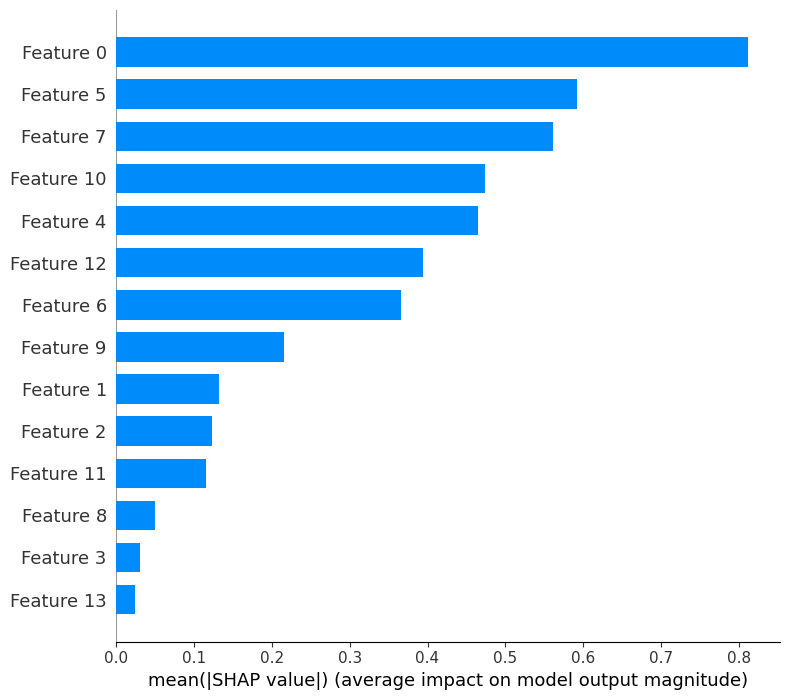

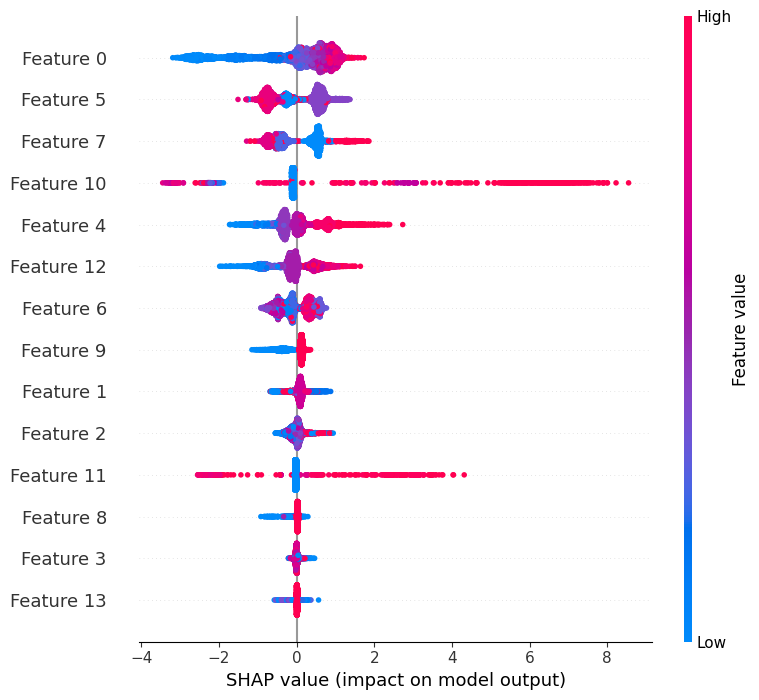

In [46]:
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

# Predict New Data

In [47]:
new_data = np.array([[40, 4, 80000, 9, 9, 0, 4, 0, 4, 1, 0, 1000, 50, 39]])
new_data_scaled = scaler.transform(new_data)
result = best_model.predict(new_data_scaled)

In [48]:
if result == [0]:
    print("\nPredicted Income: Below $50K/year")
else:
    print("\nPredicted Income: Above $50K/year")


Predicted Income: Below $50K/year
